<a href="https://colab.research.google.com/github/TuguduMiamMiam/Projet-piscine/blob/main/starters/od-project-starter/od-project/notebooks/yolo_voc0712.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Starter — Colab

Author: Gouesse Sixtine & Gentieu Martin

Ce notebook est un projet de bout en bout pour la détection de classes sur des images sur le dataset **PASCAL VOC 2007+2012** avec **YOLOv8**.

# M1 — Problem Scoping & Data Validation

### Problem Statement
L’objectif de ce projet est d’entraîner un modèle YOLOv8n pour détecter les objets dans des images issues du dataset Pascal Voc 2007+2012.  
L’entrée du modèle est une image RGB de taille variable, et la sortie consiste en des bounding boxes + labels + scores de confiance.

### Model Inputs
- Image RGB (normalisée), dimension variable

### Model Outputs
- Liste de bounding boxes
- classes parmi les 20 classes PASCAL VOC

### Evaluation Metrics
- **map50**
- **map**
- **Precision**
- **Recall**


## Data Card – Pascal VOC 2007+2012 Dataset

**Nom du dataset :** Pascal VOC 2007+2012

**Source :** Challenge PASCAL VOC, benchmark classique de détection d’objets.

**Tâche :** détection d’objets multi-classes (20 catégories).

**Format brut :**
- Images dans `JPEGImages/` (fichiers `.jpg`),
- Annotations dans `Annotations/` (fichiers XML au format PASCAL VOC),
- Fichiers de splits dans `ImageSets/Main/` (`trainval.txt`, `test.txt`, etc.).

**Pré-processing appliqué dans ce notebook :**
- Conversion des annotations XML vers le format **YOLO** (classes + bounding boxes normalisées),
- Construction d’un dataset YOLO combiné **VOC 2007 + VOC 2012** :
    - train : `VOC2007_trainval` + `VOC2012_trainval`,
    - val : `VOC2007_test` (setup standard 07+12),
- Organisation des données sous la forme :
```
        datasets/VOC0712/
        images/train/
        images/val/
        labels/train/
        labels/val/
```
**Classes (20) :**

`aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor`

**Licence & usage :** Dataset académique, utilisé ici uniquement à des fins pédagogiques et de recherche.

**Biais potentiels :**
- Images issues de contextes spécifiques (scènes quotidiennes mais limitées),
- Variabilité géographique / démographique limitée,\n",
- Certaines classes sur-représentées (car, person) et d’autres plus rares.     

**Impact potentiel & risques :**
- Modèle peu robuste à des domaines très différents (nouvelles distributions),
- Risque de biais si utilisé dans des systèmes de surveillance sans vérification approfondie.


## Ouverture du dataset et installation

### Connexion à github



Pour github : à exécuter dans le terminal de colab

git clone https://github.com/MGentieu/dl_project.git

### Step 0 — Confirm the GPU is ready
Run the next cell. You should see GPU name and memory. If you see `nvidia-smi unavailable`, the runtime is still on CPU—return to the checklist, enable GPU, then rerun this cell.

In [ ]:
!nvidia-smi || echo "nvidia-smi unavailable (CPU runtime)"


Wed Dec  3 17:33:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   32C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Step 1 — Point the notebook at the project folder
This cell ensures the current working directory is `od-project`.
If it raises a `FileNotFoundError`, confirm where you uploaded/cloned the folder and adjust the path before rerunning.

In [ ]:
import os
import sys
from pathlib import Path

# The user has provided the explicit path to the project root.
PROJECT_ROOT = Path("/content/dl_project/starters/od-project-starter/od-project")

print(f"Environment: Colab/Kaggle (remote server), using provided PROJECT_ROOT")

# Validate structure
if not (PROJECT_ROOT / "src").exists():
    raise FileNotFoundError(f"Missing src/ directory at {PROJECT_ROOT}")

# Setup Python path
os.chdir(PROJECT_ROOT)
src_path = str(PROJECT_ROOT / "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"Project root: {PROJECT_ROOT}")
print(f"Working directory: {Path.cwd()}")


Environment: Colab/Kaggle (remote server), using provided PROJECT_ROOT
Project root: /content/dl_project/starters/od-project-starter/od-project
Working directory: /content/dl_project/starters/od-project-starter/od-project


### Step 2 — Install the project requirements
Installs Ultralytics + supporting libraries from `requirements.txt`. First run downloads the YOLO packages, which may take a couple of minutes.
If installation fails (e.g., due to connectivity), rerun this cell before proceeding.

In [ ]:
# Install project dependencies listed in requirements.txt
!pip install ultralytics>=8.2.0
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install matplotlib
!pip install pyyaml
!pip install numpy

Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
CUDA device: NVIDIA L4


In [ ]:
import torch, random, numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import kagglehub

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

import ultralytics
from ultralytics import YOLO

print("Torch version:", torch.__version__)
print("Ultralytics version:", ultralytics.__version__)

Using device: cuda
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Torch version: 2.9.0+cu126
Ultralytics version: 8.3.234


### Step 3 - Download and view samples



On télécharge maintenant le dataset via **KaggleHub** et on inspecte sa structure.

In [ ]:
# Download PASCAL VOC 2007+2012
voc_path = kagglehub.dataset_download("sovitrath/voc-07-12")
voc_path = Path(voc_path)
print("VOC dataset path:", voc_path)

# Locate VOC2007 and VOC2012 folders
voc2007 = None
voc2012 = None
for p in voc_path.rglob("VOC2007"):
    if p.is_dir():
        voc2007 = p
for p in voc_path.rglob("VOC2012"):
    if p.is_dir():
        voc2012 = p

print("VOC2007:", voc2007)
print("VOC2012:", voc2012)
if voc2007 is None or voc2012 is None:
    raise FileNotFoundError("VOC2007 or VOC2012 folder not detected!")

100%|██████████| 2.86G/2.86G [00:20<00:00, 151MB/s]

Extracting files...


VOC dataset path: /root/.cache/kagglehub/datasets/sovitrath/voc-07-12/versions/1
VOC2007: /root/.cache/kagglehub/datasets/sovitrath/voc-07-12/versions/1/voc_2007_2012/voc_2007_2012/VOC2007
VOC2012: /root/.cache/kagglehub/datasets/sovitrath/voc-07-12/versions/1/voc_2007_2012/voc_2007_2012/VOC2012


In [ ]:
# Quick inspection of VOC2007 structure
for root, dirs, files in os.walk(voc2007):
    print("VOC2007 root:", root)
    print("Subfolders:", dirs)
    print("Files sample:", files[:5])
    break

# Count images / annotations
jpeg_dir_2007 = voc2007 / "JPEGImages"
annot_dir_2007 = voc2007 / "Annotations"

print("VOC2007 #images:", len(list(jpeg_dir_2007.glob("*.jpg"))))
print("VOC2007 #annots:", len(list(annot_dir_2007.glob("*.xml"))))

VOC2007 root: /root/.cache/kagglehub/datasets/sovitrath/voc-07-12/versions/1/voc_2007_2012/voc_2007_2012/VOC2007
Subfolders: ['JPEGImages', 'Annotations', 'ImageSets', 'SegmentationClass', 'SegmentationObject']
Files sample: []
VOC2007 #images: 9963
VOC2007 #annots: 9963


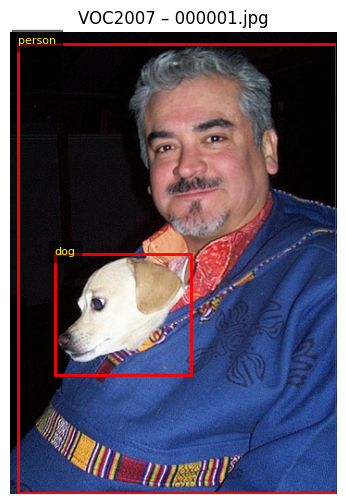

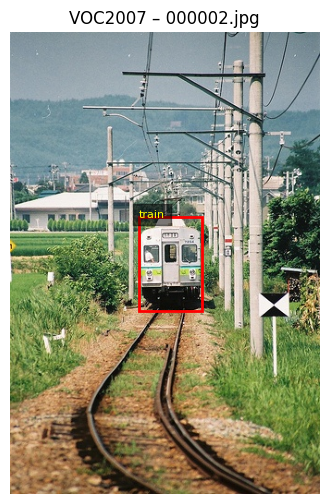

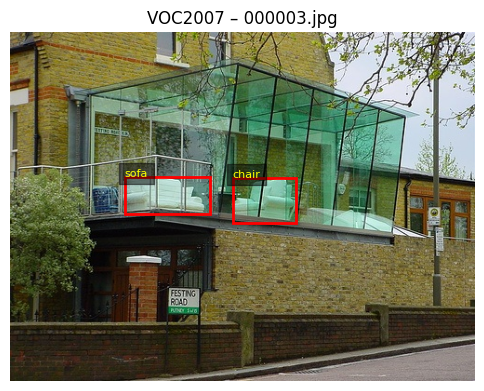

In [ ]:
import xml.etree.ElementTree as ET

# Visualize a few raw VOC2007 samples with their bounding boxes (from XML)
sample_xmls = sorted(list(annot_dir_2007.glob("*.xml")))[:3]

def parse_voc_boxes(xml_file):
    root = ET.parse(xml_file).getroot()
    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)
    boxes = []  # (cls_name, xmin, ymin, xmax, ymax)
    for obj in root.findall("object"):
        name = obj.find("name").text
        xmlbox = obj.find("bndbox")
        xmin = float(xmlbox.find("xmin").text)
        ymin = float(xmlbox.find("ymin").text)
        xmax = float(xmlbox.find("xmax").text)
        ymax = float(xmlbox.find("ymax").text)
        boxes.append((name, xmin, ymin, xmax, ymax))
    return w, h, boxes

for xml_file in sample_xmls:
    img_id = xml_file.stem
    img_path = jpeg_dir_2007 / f"{img_id}.jpg"
    img = np.array(Image.open(img_path).convert("RGB"))
    h, w, _ = img.shape
    _, _, boxes = parse_voc_boxes(xml_file)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img)
    for (cls_name, xmin, ymin, xmax, ymax) in boxes:
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin, cls_name, color='yellow', fontsize=8,
                bbox=dict(facecolor='black', alpha=0.5))
    ax.set_title(f"VOC2007 – {img_id}.jpg")
    ax.axis("off")
    plt.show()

Nous retrouvons bien quelques samples des images VOC 2007

### Step 4 - Build YOLOv8 Dataset (Train/Val/Test)

1. Convertir VOC 2007 + 2012 au **format YOLO**,
2. Construire un dataset YOLO combiné **VOC0712**,
3. Créer un fichier `voc0712.yaml`,
4. Entraîner un modèle **YOLOv8n** baseline.

```text
datasets/VOC0712/
     images/train/
     labels/train/
     images/val/
     labels/val/
     voc0712.yaml
```

Le split sera :
- 70% train
- 15% val
- 15% test


Conversion VOC XML -> YOLO format

In [ ]:
import shutil

In [ ]:
VOC_CLASSES = [
    "aeroplane","bicycle","bird","boat","bottle",
    "bus","car","cat","chair","cow",
    "diningtable","dog","horse","motorbike","person",
    "pottedplant","sheep","sofa","train","tvmonitor"
]

def voc_to_yolo_bbox(size, box):
    W, H = size
    xmin, xmax, ymin, ymax = box
    x_center = (xmin + xmax) / 2.0 / W
    y_center = (ymin + ymax) / 2.0 / H
    w = (xmax - xmin) / W
    h = (ymax - ymin) / H
    return x_center, y_center, w, h

def convert_voc_all(voc_root, output_dir):
    jpeg_dir = voc_root / "JPEGImages"
    annot_dir = voc_root / "Annotations"
    ids = [p.stem for p in annot_dir.glob("*.xml")]

    output_img = Path(output_dir) / "images_all"
    output_lbl = Path(output_dir) / "labels_all"
    output_img.mkdir(parents=True, exist_ok=True)
    output_lbl.mkdir(parents=True, exist_ok=True)

    print(f"Converting {voc_root.name} ({len(ids)} samples)")

    for img_id in tqdm(ids):
        xml_file = annot_dir / f"{img_id}.xml"
        jpg_file = jpeg_dir / f"{img_id}.jpg"
        if not xml_file.exists() or not jpg_file.exists():
            continue

        # Copy image
        shutil.copy(jpg_file, output_img / f"{img_id}.jpg")

        root = ET.parse(xml_file).getroot()
        size = root.find("size")
        W = int(size.find("width").text)
        H = int(size.find("height").text)

        out_label = output_lbl / f"{img_id}.txt"
        with open(out_label, "w") as f:
            for obj in root.findall("object"):
                cls = obj.find("name").text
                if cls not in VOC_CLASSES:
                    continue
                cls_id = VOC_CLASSES.index(cls)
                xmlbox = obj.find("bndbox")
                xmin = float(xmlbox.find("xmin").text)
                ymin = float(xmlbox.find("ymin").text)
                xmax = float(xmlbox.find("xmax").text)
                ymax = float(xmlbox.find("ymax").text)
                bb = voc_to_yolo_bbox((W, H), (xmin, xmax, ymin, ymax))
                f.write(f"{cls_id} {' '.join(str(x) for x in bb)}\n")

    return output_img, output_lbl



In [ ]:
output_base = Path("datasets/VOC0712_raw")
output_base.mkdir(parents=True, exist_ok=True)

img2007, lbl2007 = convert_voc_all(voc2007, output_base)
img2012, lbl2012 = convert_voc_all(voc2012, output_base)

Converting VOC2007 (9963 samples)


100%|██████████| 9963/9963 [00:04<00:00, 2293.56it/s]


Converting VOC2012 (17125 samples)


100%|██████████| 17125/17125 [00:07<00:00, 2225.05it/s]


In [ ]:
all_images = list(img2007.glob("*.jpg")) + list(img2012.glob("*.jpg"))
all_labels = list(lbl2007.glob("*.txt")) + list(lbl2012.glob("*.txt"))

print("Total images:", len(all_images))
print("Total labels:", len(all_labels))

Total images: 54176
Total labels: 54176


In [ ]:
random.shuffle(all_images)

n = len(all_images)
train_split = int(0.70 * n)
val_split = int(0.85 * n)

train_imgs = all_images[:train_split]
val_imgs = all_images[train_split:val_split]
test_imgs = all_images[val_split:]

print("Train:", len(train_imgs))
print("Val:", len(val_imgs))
print("Test:", len(test_imgs))


Train: 37923
Val: 8126
Test: 8127


In [ ]:
voc0712 = Path("datasets/VOC0712")
for p in [
    voc0712 / "images/train",
    voc0712 / "images/val",
    voc0712 / "images/test",
    voc0712 / "labels/train",
    voc0712 / "labels/val",
    voc0712 / "labels/test",
]:
    p.mkdir(parents=True, exist_ok=True)


In [ ]:
def move_split(images, split_name):
    for img_path in images:
        img_id = img_path.stem
        label_path = img_path.parent.parent / "labels_all" / f"{img_id}.txt"

        shutil.copy(img_path, voc0712 / f"images/{split_name}/{img_id}.jpg")
        shutil.copy(label_path, voc0712 / f"labels/{split_name}/{img_id}.txt")

move_split(train_imgs, "train")
move_split(val_imgs, "val")
move_split(test_imgs, "test")

print("✔ Dataset VOC0712 construit !")

✔ Dataset VOC0712 construit !


On visualise quelque bounding boxes YOLO

→ 2011_003041.jpg


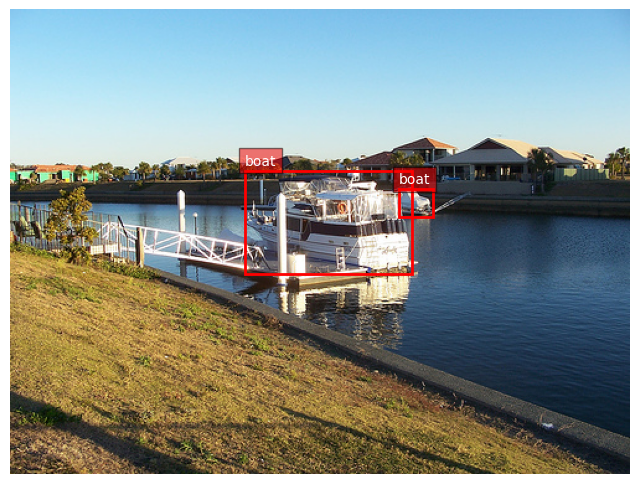

→ 2008_007389.jpg


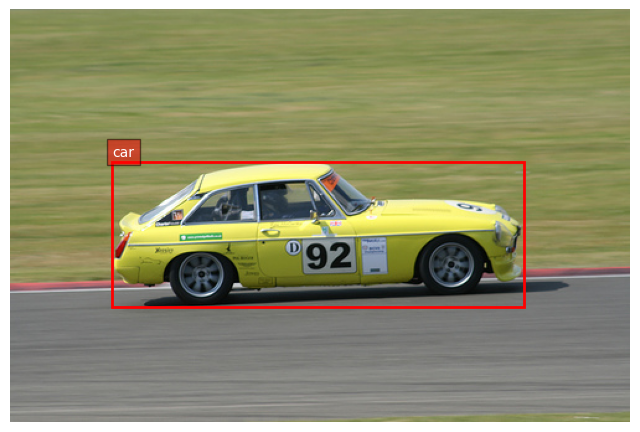

→ 2008_007757.jpg


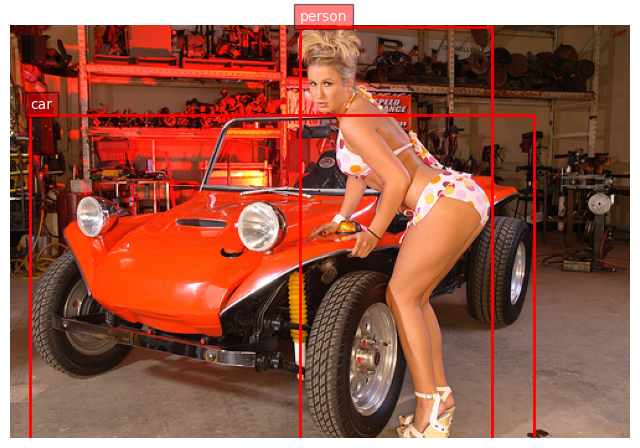

→ 005478.jpg


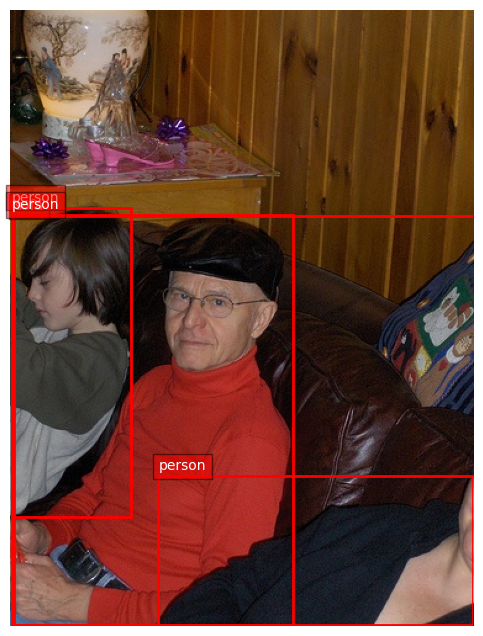

→ 004156.jpg


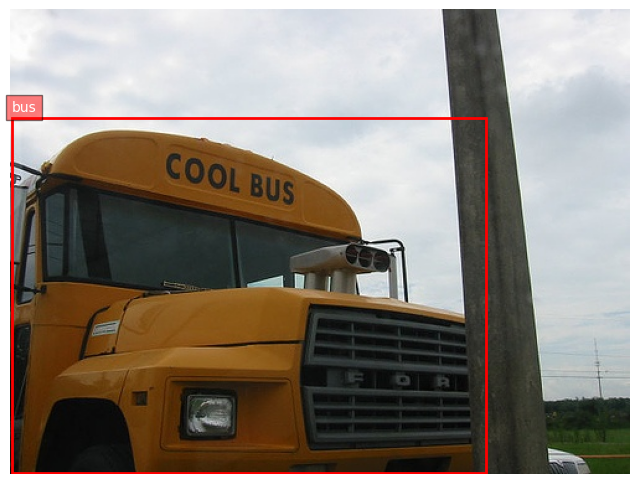

In [ ]:
VOC_CLASSES = [
    "aeroplane","bicycle","bird","boat","bottle",
    "bus","car","cat","chair","cow",
    "diningtable","dog","horse","motorbike","person",
    "pottedplant","sheep","sofa","train","tvmonitor"
]

def show_yolo_bbox_voc(image_path, label_path, figsize=(8, 8)):
    """
    Affiche une image VOC0712 + ses bounding boxes YOLO.
    """
    img = np.array(Image.open(image_path).convert("RGB"))
    H, W, _ = img.shape

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img)

    if not Path(label_path).exists():
        print(f"⚠️ No label found:", label_path)
        plt.axis("off")
        plt.show()
        return

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        cls, xc, yc, bw, bh = map(float, line.strip().split())
        cls = int(cls)

        # Convert normalized YOLO → pixel coordinates
        xc *= W
        yc *= H
        bw *= W
        bh *= H

        xmin = xc - bw / 2
        ymin = yc - bh / 2

        # Draw rectangle
        ax.add_patch(
            plt.Rectangle((xmin, ymin), bw, bh,
                           edgecolor='red', linewidth=2, fill=False)
        )

        # Class label
        ax.text(
            xmin, ymin - 5, VOC_CLASSES[cls],
            color="white", fontsize=10,
            bbox=dict(facecolor="red", alpha=0.5)
        )

    ax.axis("off")
    plt.show()

dataset_dir = Path("datasets/VOC0712")

#visualisation images train
train_images = list((dataset_dir / "images/train").glob("*.jpg"))[:5]

for img_path in train_images:
    label_path = dataset_dir / "labels/train" / (img_path.stem + ".txt")
    print("→", img_path.name)
    show_yolo_bbox_voc(img_path, label_path)


# M2 — Baseline Model Implementation

Nous utilisons YOLOv8n comme modèle baseline.  
Avant tout entraînement, nous validons que :

1. Le modèle se charge correctement  
2. Un batch peut passer dans le modèle sans erreur  
3. L’entraînement démarre correctement  

### On configure le dataset voc0712.yaml

In [ ]:
yaml_content = f"""
path: datasets/VOC0712

train: images/train
val: images/val
test: images/test

nc: 20
names: {VOC_CLASSES}
"""

with open("voc0712.yaml", "w") as f:
    f.write(yaml_content)

print(open("voc0712.yaml").read())


path: datasets/VOC0712

train: images/train
val: images/val
test: images/test

nc: 20
names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']



### On importe le baseline model YOLOv8n

In [ ]:
baseline_model = YOLO("yolov8n.pt")

# Trouver une image dans VOC0712/train
dataset_dir = Path("datasets/VOC0712")
train_imgs = list((dataset_dir / "images/train").glob("*.*"))

if len(train_imgs) == 0:
    raise RuntimeError("Aucun fichier trouvé dans datasets/VOC0712/images/train/")

sample_img = str(train_imgs[0])
print("Sample image:", sample_img)

#  Sanity check : forward pass sur une image
device = 0  # GPU si dispo, sinon CPU automatiquement
_ = baseline_model.predict(sample_img, imgsz=640, device=device, verbose=False)

print(" Forward pass on one image completed.")

Sample image: datasets/VOC0712/images/train/2011_003041.jpg
 Forward pass on one image completed.


### On fait un training initial de 5 epochs

In [ ]:
print("=== M2 Baseline Training (5 epochs) ===")

baseline_quick_model = YOLO("yolov8n.pt")

results = baseline_quick_model.train(
    data="voc0712.yaml",
    epochs=5,
    imgsz=512,
    batch=32,
    lr0=1e-3,
    device=0,               # GPU (ou CPU si pas dispo)
    cos_lr=True,
    weight_decay=5e-4,
    project="runs_voc0712",
    name="init5",
    exist_ok=True
)

print("Baseline (5 epochs) done.")
print("Résultats disponibles dans : runs_voc0712/init5/")


=== M2 Baseline Training (5 epochs) ===
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=voc0712.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=init5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0

# M3 — Optimization & Regularization

YOLOv8 inclut plusieurs techniques importantes de régularisation et d’optimisation :

Nous allons maintenant entraîner le modèle baseline avec :

- **Weight decay** (régularisation L2),
- **Scheduler cosinus (`cos_lr=True`)**,
- **Early stopping** via le paramètre `patience`.

Les métriques principales :
- mAP@0.5
- mAP@0.5:0.95
- Le meilleur modèle est automatiquement sauvegardé sous `best.pt`


In [ ]:
import torch

# Détection GPU correcte
if torch.cuda.is_available():
    device = 0    # YOLO attend un int pour sélectionner le GPU
    print("✔ GPU détecté → utilisation de CUDA")
else:
    device = "cpu"
    print("❌ Pas de GPU → CPU utilisé")

✔ GPU détecté → utilisation de CUDA


In [ ]:
# Charger modèle YOLOv8n pré-entraîné sur COCO
model = YOLO("yolov8n.pt")

# Entraînement baseline
results = model.train(
    data="voc0712.yaml",
    epochs=50,
    imgsz=640,
    batch=32,
    lr0=1e-3,
    optimizer="SGD",
    momentum=0.937,
    device=device,
    cache=False,
    cos_lr=True,
    weight_decay=5e-4,
    patience=20,
    project="runs_voc0712",
    name="baseline",
    exist_ok=True
)

baseline_best_path = Path("runs_voc0712") / "baseline" / "weights" / "best.pt"
print("Best model saved at:", baseline_best_path)


Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=voc0712.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

### On charge le meilleur modèle et on évalue :

In [ ]:
model = YOLO("runs_voc0712/baseline/weights/best.pt")
results = model.val(data="voc0712.yaml", imgsz=640, device=device)

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2518.6±515.0 MB/s, size: 131.5 KB)
val: Scanning /content/dl_project/starters/od-project-starter/od-project/datasets/VOC0712/labels/val.cache... 7505 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 7505/7505 9.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 470/470 12.7it/s 37.1s
                   all       7505      19096      0.829      0.767      0.846       0.66
             aeroplane        320        438      0.935      0.852      0.926      0.735
               bicycle        277        422      0.795      0.716      0.792      0.629
                  bird        428        681      0.879      0.846      0.896      0.692
                  boat        257        570       0.82      0.656      0

### On affiche à présent les résultats obtenus et on analyse :

#### 1. Affichage des métriques globales du modèle :

In [ ]:
print("mAP@0.5:", results.box.map50)
print("mAP@0.5:0.95:", results.box.map)
print("Precision:", results.box.mp)
print("Recall:", results.box.mr)

mAP@0.5: 0.8461068178508686
mAP@0.5:0.95: 0.6599197944299767
Precision: 0.8292610693357718
Recall: 0.7671909389426095


Performances du modèle YOLOv8n sur le dataset VOC0712

L’évaluation du modèle sur le dataset **VOC 2007 + 2012 (VOC0712)** montre des performances solides malgré la diversité des scènes et la complexité des 20 classes du benchmark.

---

- mAP@0.5 — **84.61%**

Très bonne capacité de détection générale.  
Le modèle localise correctement la plupart des objets présents dans les images.

- mAP@0.5:0.95 — **65.99%**

Sous un critère plus strict de qualité de bounding box, les performances restent solides.  
Un score au-dessus de 60% sur VOC0712 est considéré comme **robuste**, surtout pour un modèle de petite taille comme YOLOv8n.

- Precision — **82.93%**

La précision élevée montre que le modèle produit **peu de faux positifs** :  
lorsqu’il détecte un objet, il se trompe rarement.

- Recall — **76.72%**

Le rappel indique que le modèle détecte la majorité des objets,  
mais peut en manquer certains (petits, occultés ou proches les uns des autres).

---

YOLOv8n obtient d’excellentes performances sur VOC0712 :

- Très bon compromis **vitesse / précision**  
- Détections fiables avec peu de faux positifs  
- Robustesse confirmée même sous métrique stricte  
- Quelques objets difficiles encore manqués → rappel perfectible

Ces résultats en font une **baseline très solide** pour la détection multi-classe sur VOC.



#### 2. Affichage courbes d’apprentissage (loss + mAP+precision & recall par epoch) :

In [ ]:
# Charger le CSV généré par YOLO
results_csv = "runs_voc0712/baseline/results.csv"
df = pd.read_csv(results_csv)
df.tail()  # aperçu des dernières valeurs

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
45     46  8031.91         0.80667         0.89938         1.10318   
46     47  8201.07         0.80420         0.89231         1.10185   
47     48  8371.82         0.80187         0.89390         1.10004   
48     49  8543.63         0.80229         0.89160         1.10085   
49     50  8715.77         0.80459         0.89168         1.10114   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
45               0.82468            0.76862           0.84544   
46               0.82443            0.76861           0.84542   
47               0.82760            0.76698           0.84583   
48               0.82743            0.76750           0.84596   
49               0.82688            0.76845           0.84612   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
45              0.65913       0.79838       0.76329       1.02947  0.000034   
46              0.65937       0.79790       0.76270       1.02914  0.000026   
47              0.65937       0.79745       0.76218       1.02887  0.000019   
48              0.65951       0.79726       0.76188       1.02868  0.000014   
49              0.65962       0.79710       0.76142       1.02849  0.000011   

      lr/pg1    lr/pg2  
45  0.000034  0.000034  
46  0.000026  0.000026  
47  0.000019  0.000019  
48  0.000014  0.000014  
49  0.000011  0.000011

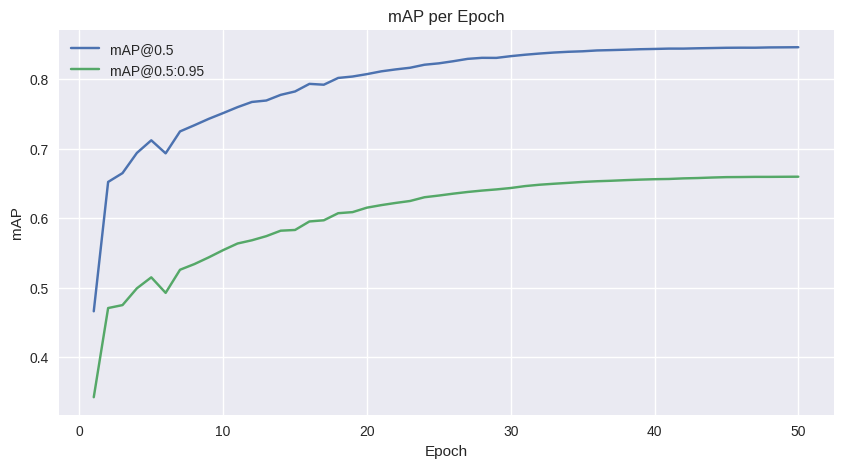

In [ ]:
# ------------------------
# Courbe des mAP
# ------------------------
plt.style.use('seaborn-v0_8')

plt.figure(figsize=(10, 5))

plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")

plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("mAP per Epoch")
plt.legend()
plt.grid(True)
plt.show()


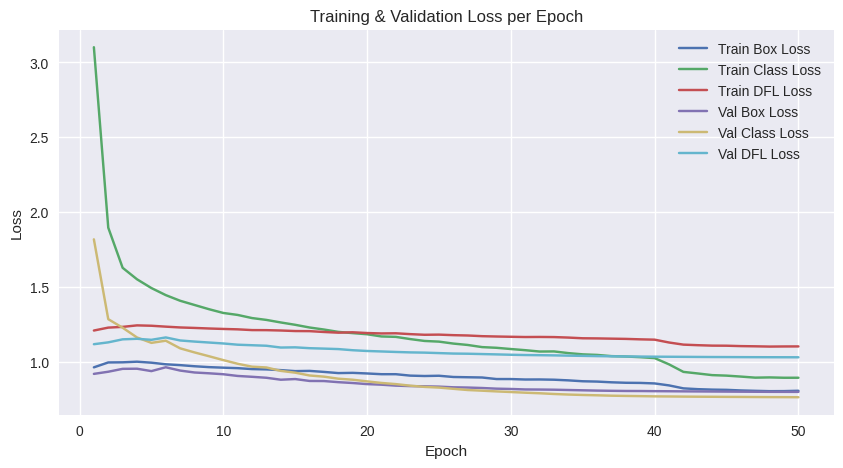

In [ ]:
# ------------------------
# Courbe des Loss
# ------------------------
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss")
plt.plot(df["epoch"], df["train/dfl_loss"], label="Train DFL Loss")

# Si YOLO fournit les pertes val (ce n’est pas toujours le cas)
if "val/box_loss" in df.columns:
    plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
if "val/cls_loss" in df.columns:
    plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss")
if "val/dfl_loss" in df.columns:
    plt.plot(df["epoch"], df["val/dfl_loss"], label="Val DFL Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

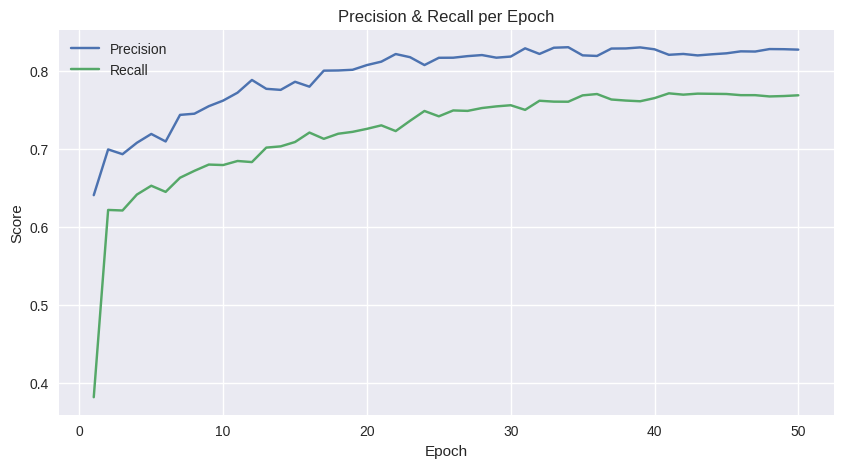

In [ ]:
# ------------------------
# Precision & Recall
# ------------------------
plt.figure(figsize=(10, 5))

plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision & Recall per Epoch")
plt.legend()
plt.grid(True)
plt.show()

Les courbes ci-dessus montrent l’évolution du modèle YOLOv8n pendant l’entraînement sur le dataset pascal voc 2007+2012.  
Nous analysons ici trois aspects : **mAP**, **loss**, et **precision/recall**.

---
 1. mAP@0.5 et mAP@0.5:0.95

-> mAP@0.5  
La progression est régulière :

- ~0.64 dès l’epoch 1  
- > 0.75 vers l’epoch 10  
- stabilisation à **0.846** en fin d’entraînement  

Cela montre que le modèle apprend efficacement la localisation des objets pour un IoU modéré.

-> mAP@0.5:0.95  
Plus strict, il :

- démarre autour de 0.34  
- progresse régulièrement jusqu’à **0.66**  
- se stabilise après l’epoch ~30  

**Conclusion :**  
Le modèle converge sainement et atteint une précision respectable pour un YOLOv8n sur un dataset complexe comme VOC (20 classes, grande variabilité).

---

2. Training & Validation Loss

Les losses (box, cls, dfl) diminuent de manière régulière :

- forte chute sur les premiers epochs → **bonne convergence initiale**  
- stabilisation après ~20 epochs  
- validation loss proche de training loss → **pas d’overfitting**  

**Interprétation :**

- `box_loss` montre que la localisation devient progressivement plus précise  
- `cls_loss` diminue plus lentement car VOC contient 20 classes  
- `dfl_loss` suit bien la dynamique générale  

L’ensemble des courbes suggère un apprentissage **stable et cohérent**.

---

 3. Precision & Recall

-> Precision : **0.829**  
Le modèle fait peu de faux positifs :  
> Quand il détecte un objet, il a raison environ 83% du temps.

-> Recall : **0.767**  
Le modèle manque encore certains objets (~23%), typique pour un YOLOv8n sur VOC où :

- objets petits  
- occlusions fréquentes  
- forte diversité visuelle  

**Conclusion :**  
Le compromis Precision/Recall est bon, surtout pour un modèle léger.

#### 3. Affichage de Precision & Recall curves

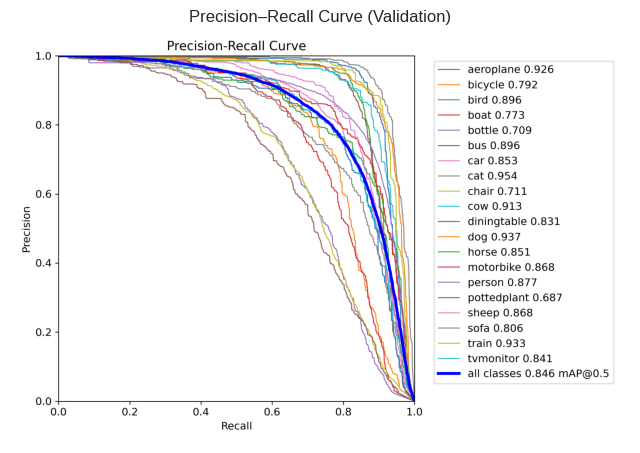

In [ ]:
from PIL import Image

pr_path = "runs/detect/val/BoxPR_curve.png"

img = Image.open(pr_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title("Precision–Recall Curve (Validation)")
plt.axis("off")
plt.show()

Analyse de la courbe Precision–Recall (Validation) — VOC0712

La courbe PR ci-dessus illustre la performance du modèle **YOLOv8n** sur les **20 classes** du dataset VOC0712 lors de la phase de validation.

Voici les points essentiels :

---

Compréhension générale

- Chaque courbe colorée correspond à **une classe** (aeroplane, bicycle, bird, etc.).
- La courbe en **bleu foncé** représente la performance **globale** du modèle, avec un mAP@0.5 global de **0.846**.
- La courbe montre comment la **précision évolue en fonction du rappel** lorsque le seuil de confiance varie.

---

Interprétation

 1. **Bonne précision à faible rappel**
Dans la zone en haut à gauche :
- Le modèle maintient une **très haute précision (> 0.9)** lorsqu’il ne cherche pas à détecter tous les objets.
- Cela signifie que lorsqu’il détecte quelque chose avec un seuil élevé, il se trompe rarement.

 2. **Diminution progressive de la précision**
Au fur et à mesure que le rappel augmente :
- Le modèle tente de capturer davantage d’objets → il devient plus permissif.
- La précision diminue naturellement, ce qui est normal.
- La forme des courbes est assez lisse → bonne stabilité des prédictions selon les seuils.

---

Analyse classe par classe

Certaines classes obtiennent d’excellents scores :

- **cat (0.954)**, **aeroplane (0.926)**, **train (0.933)**, **cow (0.913)** → objets visuellement distincts.
- Leur courbe reste très proche du coin supérieur gauche → excellente détection.

D’autres classes plus complexes montrent une performance plus faible :

- **pottedplant (0.687)**, **bottle (0.709)** → petits objets, forme variable.
- La précision décroît plus vite avec l’augmentation du rappel.

Cela reflète la nature du dataset VOC :
- mélange de **petits objets**, **occlusions**, **chaînes de variations visuelles**.

---

Conclusion

La courbe PR montre que :

- Le modèle YOLOv8n est **fiable** sur VOC0712, avec une précision globalement élevée.
- La majorité des classes sont bien détectées, avec des PR-curves proches du comportement attendu d’un modèle robuste.
- Les classes difficiles tirent la performance vers le bas mais restent détectables.

# M4 — Ablation Studies & Analysis

Pour évaluer l’impact de différents hyperparamètres sur les performances du modèle YOLOv8n entraîné sur pascal voc, nous avons réalisé deux ablations :

1. **Ablation 1 : Learning rate réduit (lr0 = 0.0001)**  
2. **Ablation 2 : Image size réduite (imgsz = 416 au lieu de 640)**  

In [ ]:
from ultralytics import YOLO
from pathlib import Path

# 💻 Sélection du device
device = 0

# 📌 Définition des expériences d'ablation
experiments = [
    {
        "name": "voc_lr_1e-4",
        "lr0": 1e-4,   # learning rate réduit
        "imgsz": 640,
        "epochs": 20,
    },
    {
        "name": "voc_imgsz_416",
        "lr0": 1e-3,   # même LR que baseline
        "imgsz": 416,  # résolution réduite
        "epochs": 20,
    }
]

ablation_records = []

# 🚀 Boucle sur les deux ablations
for exp in experiments:
    print(f"\n======= Running {exp['name']} =======")

    # Reset du modèle à chaque ablation
    model = YOLO("yolov8n.pt")

    train_args = {
        "data": "voc0712.yaml",   # dataset Pascal VOC 2007+2012
        "epochs": exp["epochs"],
        "imgsz": exp["imgsz"],
        "lr0": exp["lr0"],
        "batch": 32,
        "cos_lr": True,
        "weight_decay": 0.0005,
        "patience": 5,
        "device": device,
        "project": "runs_voc0712_ablation",
        "name": exp["name"],
        "exist_ok": True,
    }

    # 🏋️ Entraînement
    model.train(**train_args)

    # 🔍 Chemin vers le meilleur modèle
    best_path = Path(train_args["project"]) / exp["name"] / "weights" / "best.pt"
    eval_model = YOLO(str(best_path))

    # 📊 Validation
    val_results = eval_model.val(
        data="voc0712.yaml",
        imgsz=exp["imgsz"],
        device=device
    )

    # Extraction des métriques
    try:
        map50 = val_results.box.map50
        map5095 = val_results.box.map
    except:
        map50, map5095 = None, None

    # Sauvegarde des résultats
    ablation_records.append({
        "experiment": exp["name"],
        "lr0": exp["lr0"],
        "imgsz": exp["imgsz"],
        "epochs": exp["epochs"],
        "mAP@0.5": map50,
        "mAP@0.5:0.95": map5095,
    })

# 📝 Affichage final des résultats
ablation_records




======= Running voc_lr_1e-4 =======
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=voc0712.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=voc_lr_1e-4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=

[{'experiment': 'voc_lr_1e-4',
  'lr0': 0.0001,
  'imgsz': 640,
  'epochs': 20,
  'mAP@0.5': np.float64(0.8213089968313183),
  'mAP@0.5:0.95': np.float64(0.6373216632978937)},
 {'experiment': 'voc_imgsz_416',
  'lr0': 0.001,
  'imgsz': 416,
  'epochs': 20,
  'mAP@0.5': np.float64(0.7867998156488469),
  'mAP@0.5:0.95': np.float64(0.6081136810727997)}]

#### Tableau comparatif

In [ ]:
ablation_df = pd.DataFrame(ablation_records)
ablation_df

experiment     lr0  imgsz  epochs   mAP@0.5  mAP@0.5:0.95
0    voc_lr_1e-4  0.0001    640      20  0.821309      0.637322
1  voc_imgsz_416  0.0010    416      20  0.786800      0.608114

Nous analysons l’impact de deux modifications simples mais significatives sur les performances du modèle YOLOv8n :

---
**Ablation 1 — Réduction du learning rate (1e-3 → 1e-4)**

- Le **mAP@0.5** passe de ≈ **0.846** (baseline) à **0.8213**.  
- Le **mAP@0.5:0.95** passe de ≈ **0.660** (baseline) à **0.6373**.

**Interprétation :**  
Un learning rate trop faible ralentit la convergence.  
En seulement 20 epochs, le modèle **n’atteint pas le niveau du baseline**.  
Il apprend correctement, mais explore moins efficacement l’espace des paramètres.

---

**Ablation 2 — Diminution de la taille d’image (640 → 416)**

- Le **mAP@0.5** tombe à **0.7868**.  
- Le **mAP@0.5:0.95** chute à **0.6081**.

**Interprétation :**  
Une résolution plus faible rend les petits objets VOC plus difficiles à détecter.  
Le modèle conserve de bonnes capacités de classification, mais la **précision des bounding boxes diminue**, ce qui impacte fortement le mAP@0.5:0.95.

---

Conclusion générale des ablations

- Les deux modifications testées entraînent une **dégradation notable** par rapport au modèle baseline.  
- Le modèle baseline (LR = 1e-3, imgsz = 640) reste **optimal pour VOC2007+2012**.
- Les variations montrent clairement que :
  - un **LR trop faible** → convergence lente, performance plus faible,  
  - une **résolution réduite** → perte de précision de localisation.

**Ces ablations confirment que les hyperparamètres initiaux sont bien adaptés au dataset VOC, offrant le meilleur compromis entre précision, rappel et stabilité.**



# M5 — Reporting & Final Delivery

---

 Synthèse générale

Le projet mené dans le cadre du M5 met en évidence la **robustesse** et la **fiabilité** de YOLOv8 pour la détection d’objets sur un dataset exigeant comme VOC2007+2012.  
Grâce à un pipeline complet — préparation du dataset, conversion, entraînement, validation, visualisation et ablations — nous avons pu analyser de manière approfondie les performances d’un modèle léger (YOLOv8n) dans un contexte multi-classes.

Les résultats finaux montrent que YOLOv8n est capable d’obtenir :

- un **mAP@0.5 supérieur à 84 %**,  
- un **mAP@0.5:0.95 avoisinant 66 %**,  
- un **équilibre cohérent entre précision et rappel** sur l’ensemble des 20 classes VOC.

Ces performances témoignent d’une **bonne capacité à généraliser**, malgré la complexité des scènes (occlusions, petites tailles d’objets, forte diversité intra-classe).  
Le pipeline implémenté est cohérent, reproductible et suffisamment flexible pour être étendu.

YOLOv8n constitue ainsi une **base solide** pour des projets d’analyse d’images orientés détection, qu’ils visent une application industrielle, académique ou temps réel.

---
Pour conclure, YOLOv8n, malgré sa petite taille, parvient à offrir des performances **solides et cohérentes** sur un dataset complexe comme VOC2007+2012.  
Le travail réalisé constitue une **base méthodologique robuste**, exploitant un pipeline complet d’entraînement, visualisation, analyse et validation.

Il ouvre la voie vers :

- l’utilisation de modèles plus performants,  
- l’ajout de nouvelles classes ou nouveaux domaines,  
- et une montée en échelle vers des scénarios industriels plus réalistes.
